# Discriminative Biclustering Algorithm 
Proposed by Odibat & Reddy, 2014 in **Efficient mining of discriminative co-clusters from gene
expression data**

In [1]:
%load_ext pycodestyle_magic

In [2]:
%matplotlib inline
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.metrics import consensus_score
import multiprocessing as mp
import pandas as pd
import glob as glob
from functools import reduce

In [4]:
# !pip install pycodestyle
# !pip install pycodestyle_magic

### Definition 1 - Coherence Measure H

In [3]:
#%pycodestyle
class CoherenceMeasure(object):
    def __init__(self, data):
        self.data = data
        self.n, self.m = data.shape
        self.xiJ = np.mean(data, axis=1)
        self.xIj = np.mean(data, axis=0)
        self.xIJ = np.mean(data)
        self._H = None

    @property
    def H(self):
        if self._H is None:
            print("Computing coherence measure")
            self._H = self._compute_H()
            print("H value: " + str(self._H))
        return self._H
    
    def _compute_H(self):
        H = 0
        for i in range(self.n):
            for j in range(self.m):
                H += (self.data[i, j] - self.xIj[j] -
                      self.xiJ[i] + self.xIJ)**2
        H *= 1.0/math.fabs(self.m*self.n)
        H = 1 - H
        return H

#### Loading test data for Coherence Measure

In [4]:
import random
data = np.random.random((50, 50))
print(data)

[[ 0.87426777  0.23264193  0.49488635 ...,  0.43157877  0.23196908
   0.94369486]
 [ 0.19279925  0.26426963  0.27284129 ...,  0.57197032  0.18804943
   0.14928147]
 [ 0.2857795   0.08995835  0.62883951 ...,  0.88306076  0.69264995
   0.07203184]
 ..., 
 [ 0.11157932  0.12408198  0.92286694 ...,  0.22565307  0.24864138
   0.61205152]
 [ 0.90678421  0.03268699  0.78134208 ...,  0.03998985  0.30385596
   0.58319474]
 [ 0.44018822  0.30425343  0.97171935 ...,  0.8163351   0.19616119
   0.44353343]]


In [5]:
# Testing Coherence
coherence_measure = CoherenceMeasure(data)
print("H = " + str(coherence_measure.H))

Computing coherence measure
H value: 0.919034599018
H = 0.919034599018


### Definition 2 - Positive and negative correlations

In [6]:
# input: rows x and y and J columns
# output: positive and negative correlations


class PositiveNegativeCorrelation(object):
    def __init__(self, x, y, J):
        self._x = x
        self._y = y
        self._J = J
        self._x_mean = np.mean(x)
        self._y_mean = np.mean(y)
        self._H_pos = None
        self._H_neg = None

    @property
    def H_pos(self):
        if self._H_pos is None:
            # print("Computing H positive...")
            self._H_pos = self._compute_H_pos()
            # print("H positive value: " + str(self._H_pos))
        return self._H_pos

    @property
    def H_neg(self):
        if self._H_neg is None:
            # print("Computing H negative...")
            self._H_neg = self._compute_H_neg()
            # print("H negative value: " + str(self._H_neg))
        return self._H_neg

    def _compute_H_pos(self):
        H_pos = 0
        for j in range(self._J):
            aux = (((self._x[j] - self._x_mean) -
                    (self._y[j] - self._y_mean))/2.0)**2
            H_pos += aux
        H_pos *= 1.0/math.fabs(self._J)
        H_pos = 1 - H_pos
        return H_pos

    def _compute_H_neg(self):
        H_neg = 0
        for j in range(self._J):
            aux = (((self._x[j] - self._x_mean) +
                    (self._y[j] - self._y_mean))/2.0)**2
            H_neg += aux
        H_neg *= 1.0/math.fabs(self._J)
        H_neg = 1 - H_neg
        return H_neg

#### Loading test data for positive and negative correlation

In [7]:
x = np.random.random((5))
y = np.random.random((5))
J = 5
print("Row x " + str(x))
print("Row y " + str(y))
print("J value " + str(J))

Row x [ 0.55317234  0.9115416   0.91860091  0.75331959  0.75805542]
Row y [ 0.74474406  0.58136519  0.30983438  0.05064852  0.87376606]
J value 5


In [8]:
# Testing correlation
positive_negative_correlation = PositiveNegativeCorrelation(x,y,J)
print("H positive " + str(positive_negative_correlation.H_pos))
print()
print("H negative " + str(positive_negative_correlation.H_neg))

H positive 0.966631986963

H negative 0.980095606363


### Definition 3 - Pair-based coherence

#### Loading test data for pair-based coherence

In [243]:
#%%pycodestyle

# input: co-cluster X of I rows and J columns
# output: paired-based coherence


class PairBasedCoherence(object):
    def __init__(self, X):
        self._X = np.array(X)
        self._I, self._J = X.shape
        self._HP = None

    @property
    def HP(self):
        if self._HP is None:
            # print("Calculating Pair based coherence..")
            self._HP = self._compute_HP_()
            # print("Paired based coherence value: " + str(self._HP))
        return self._HP

    def _compute_HP_(self):
        HP = 0
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i==j): 
                    break
                x = self._X[i]
                y = self._X[j]
                correlation = PositiveNegativeCorrelation(x, y,self._J)
                H0 = correlation.H_pos
                # H0 = max(correlation.H_pos,correlation.H_neg)
                HP += H0
        HP *= math.fabs(2.0)/(math.fabs(self._I)*(math.fabs(self._I)-1)) if self._I > 1 else 0
        
        return HP

In [244]:
data = np.random.random((50, 50))
print(data)

[[ 0.82687622  0.65300237  0.92715042 ...,  0.06522503  0.9631487
   0.11894567]
 [ 0.00207856  0.84578095  0.99818956 ...,  0.55962602  0.62852775
   0.36181292]
 [ 0.12137228  0.62015641  0.83642665 ...,  0.79678005  0.65342337
   0.05411773]
 ..., 
 [ 0.67338921  0.16550931  0.93138261 ...,  0.63571411  0.68772182
   0.69384757]
 [ 0.25333744  0.3799097   0.20294356 ...,  0.14353984  0.74306274
   0.35549273]
 [ 0.78220363  0.91268743  0.00306531 ...,  0.08142986  0.81622029
   0.31281387]]


In [245]:
pair_based_coherence = PairBasedCoherence(data)
print("H value " + str(pair_based_coherence.HP))

H value 0.959984260392


### Coherence for a new z in in X

In [235]:
%%latex
Define H for a new term 'z' in X
$$
H_{1}(I,J,X,z) =H_{0}(I,J,X) \cdot \frac{(I-1)}{(I+1)} + \frac{|2|}{(I)(I+1)} \cdot \sum_{x \epsilon X} {h(x,z,J)}
$$

<IPython.core.display.Latex object>

### RAPOOC

This algorithm is proposed to efficiently extract the most coherent and large co-clusters that area arbitrarily positioned in the data matrix.



#### Algorithm 1 RAPOOC (D,k,l,K)
Input: Data matrix D, number of row clusters (k), number of column clusters (l), number of optimized co-clusters (K)

Output: A set of K co-clusters({X})

In [247]:
data = pd.read_csv('TestData/SimulatedDataCoherence/RandData.csv',header=None)
data.head()

,0,1,2,3,4,5,6
0,0.029469,0.45006,0.207910,0.052621,0.57575,0.42221,0.59412
1,0.357910,0.62144,0.579620,0.679850,0.12174,0.76694,0.27906
2,0.447640,0.18441,0.836500,1.000000,0.33869,0.96056,0.56005
3,0.781750,0.96066,0.040275,0.154620,0.54363,0.70729,0.62836
4,0.322800,0.42936,0.204720,0.650460,0.37645,0.76164,0.52247


In [237]:

class BisectingClusterer(object):
    def __init__(self, data):
        if data is not None:
            self._data = np.array(data)
            self._I, self._J = self._data.shape
        else:
            print("Empty data")
    
    @property
    def centroids(self):
        return self._centroids

    def fit(self):
        self._centroids = self._compute_centroids_()
        bisecting_indices = self._bisect_clusters_(self._centroids)
        return bisecting_indices
    
    def _compute_centroids_(self):
        max_correlation = 0
        centroids = [0,0]
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i == j):
                    break
                correlation = PositiveNegativeCorrelation(self._data[i],
                                                          self._data[j],
                                                          self._J).H_neg
                if(correlation > max_correlation):
                    max_correlation = correlation
                    centroids[0] = i
                    centroids[1] = j
        return centroids

    def _bisect_clusters_(self, centroids):
        cluster_indices = np.zeros(self._I)
        for i in range(self._I):
            correlation0 = PositiveNegativeCorrelation(
                self._data[centroids[0]], self._data[i],self._J).H_pos
            correlation1 = PositiveNegativeCorrelation(
                self._data[centroids[1]], self._data[i],self._J).H_pos
            if(correlation0 <= correlation1):
                cluster_indices[i] = 1
        return cluster_indices

In [238]:
class Rapooc(object):
    def __init__(self, D, k, l, K):
        self._D = np.array(D)
        assert k>0 and l >0, "invalid values, k>0 and l>0"
        self._k = k
        self._l = l
        assert K <= k*l and k>=1, "invalid values, 1<= K <= k*l"
        self._K = K
        self._rho = np.ones(D.shape[0])
        self._gamma = np.ones(D.shape[1])
        self._M, self._N = self._D.shape
        self._cluster_H_values = None
            
    @property
    def rho(self):
        return self._rho
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def bicluster_h_values(self):
        return self._cluster_H_values

    def initialize(self):
        i = 1
        j = 1
        while (i < self._k or j < self._l):
            if i < self._k:
                i += 1
                alpha = self._argmin_H_(self._rho, self._gamma,'row')
                self._bisect_partitions_(self._D[np.where(self._rho==alpha)], self._rho, alpha, i,'row')
            if j < self._l:
                j += 1
                beta = self._argmin_H_(self._rho,self._gamma, 'column')
                self._bisect_partitions_((self._D.T)[np.where(self._gamma==beta)], self._gamma, beta, j,'column')   

    def _argmin_H_(self, row_co_cluster, col_co_cluster,option='row'):
        if (option=='row'):
            data = self._D
        else:
            data = self._D.T
        h_min = math.inf
        min_cocluster = 1
        map_array = np.int64(row_co_cluster if option == 'row' else col_co_cluster)
        max_index_in_map = np.max(map_array)
        for i in range(1,max_index_in_map):
            if (list(map_array).count(i) < 2):
                pass
            else:
                coherence = PairBasedCoherence(
                    data[np.where((row_co_cluster if option == 'row' else col_co_cluster) == i)]).HP 
                if (coherence <= h_min):
                    h_min = coherence
                    min_cocluster = i
        return min_cocluster

    def _bisect_partitions_ (self, data, mapping_array, cluster_to_replace, new_cluster_index,option='row'):
        clusterer = BisectingClusterer(data)
        bisected_map = clusterer.fit()
        bisected_map_index = 0
        for i in range(0,len(mapping_array)):
            if ((self._rho if option == 'row' else self._gamma)[i] == cluster_to_replace):
                if (bisected_map[bisected_map_index] == 1.0):
                    (self._rho if option == 'row' else self._gamma)[i] = new_cluster_index
                bisected_map_index += 1
                          
    def core_coclustering(self):
        # self.compute_H_values()
        max_h_value = 0.0
        h_values_repetitions = 0
        flg_h_drop = False
        
        # simulated annealing?
        self._rows_delta = 0.0
        self._cols_delta = 0.0
        
        for i in range(0,10):   
            
            
            manager = mp.Manager()
            return_dict = manager.dict()
            print ("iter " +str(i))
            if (h_values_repetitions>20 or flg_h_drop):
                break;
            '''''
            # jobs
            jobs = list()
            jobs.append(mp.Process(target = self._arg_max_, args = ('row', return_dict)))
            jobs.append(mp.Process(target = self._arg_max_, args = ('column', return_dict))) 
            
            for job in jobs:
                print("starting jobs")
                job.start()
            
            #join jobs
            for job in jobs:
                print("finishing jobs")
                job.join()
            
            '''
            
            
            self._arg_max_('row', return_dict)
            # print('% debug %')
            self._arg_max_('column', return_dict)
            # '''
            
            self._rows_delta = return_dict[0]
            self._cols_delta = return_dict[1]
            actual_h_value = return_dict[0] + return_dict[1]
            # print("% debug % rows delta " + str(self._rows_delta) )
            # print("% debug % cols delta " + str(self._cols_delta) )
            # print("h value: " + str(actual_h_value))
            if(actual_h_value > max_h_value):
                max_h_value = actual_h_value
                h_values_repetitions = 0
                self._best_row_map = self._rho
                self._best_col_map = self._gamma
                
                
            elif (math.fabs(actual_h_value - max_h_value) <= 0.001):
                h_values_repetitions += 1
            else:
                h_values_repetitions = 0
                
            if (h_values_repetitions > 5):
                print("actual h value " + str(actual_h_value))
                print("max h value " + str(max_h_value))
                print("n repetitions " + str(h_values_repetitions))
                break
        
    def compute_H_values(self):
        self._cluster_H_values = np.array([ [0.0] * int(max(self._rho) + 1)  
                                           for _ in range(int(max(self._gamma) + 1))])
        for i in range(1,int(max(self._rho) + 1)):
            for j in range (1, int(max(self._gamma) + 1)):
                coherence = PairBasedCoherence(self._D[np.ix_(np.where(self._rho == i)[0],
                                                              np.where(self._gamma == j)[0])]).HP
                self._cluster_H_values[i][j] = coherence
            
    def _row_clustering_(self):
            self._rho = self._arg_max_('row')
    
    def _column_clustering_(self):
            self._gamma = self._arg_max_('column')
            
    def _arg_max_(self,option = 'row',delta = None): 
        print(" arg max " + option)
        if option == 'row':
            mapping_array = self._rho
            data = self._D
        else:
            mapping_array = self._gamma
            data = self._D.T
            
        num_of_biclusters = int(np.max(mapping_array))
        
        # initial_optimum = reduce(lambda x,y: x + y, h_values[1:int(max(mapping_array))])
        
        total_delta = 0
        for i in range (0,len(data)):
            flg_keep = True
            element = data[i]
            element_cluster = int(mapping_array[i])
            element_h = self._compute_single_h_term_(element_cluster, data, mapping_array)
            optimal_delta = 0
            if (list(mapping_array).count(element_cluster)>2):
                no_element_h = self._compute_single_h_term_(element_cluster, data, mapping_array)
                mapping_array[i] = 0
                flg_keep = (math.fabs(element_h - no_element_h) <= 0.001 )
            else: 
                flg_keep = True
            optimal_cluster = 0
            flg_h_rise = False
            for cluster in range(1,int(max(mapping_array)) +1):
                # print ("% debug % " + " max clusters "+ str(int(max(mapping_array))))
                if (cluster == element_cluster):
                    pass 
                else:
                    if ((list(mapping_array).count(i)) > 2):
                        mapping_array[i] = cluster
                        cluster_size = list(mapping_array).count(cluster)
                        h_delta = self._compute_single_h_term_(cluster, data, mapping_array)
                        # print("% debug % option " + str(option) + " h_delta " + str(h_delta))
                        if (h_delta > optimal_delta):
                            optimal_delta = h_delta
                            optimal_cluster = cluster
                            flg_h_rise = True
            
            # print("% debug % mapping cluster " + str(optimal_cluster if \
                            # flg_h_rise else \
                            # (element_cluster if flg_keep else 0)))
            mapping_array[i] =  optimal_cluster if \
                            flg_h_rise else \
                            (element_cluster if flg_keep else 0)
            total_delta += optimal_delta
        # print("% debug optimal %  " + str(total_delta))
        if option=='row':
            delta[0] = total_delta
            # print("% debug % inner rows delta " + str(delta[0]) + " total delta " + str(total_delta))
        else:
            delta[1] = total_delta
            # print("% debug % inner cols delta " + str(delta[1]) + " total delta " + str(total_delta))
        
    def _compute_single_h_term_(self, cluster, data, mapping_array):
        coherence = PairBasedCoherence(data[np.where(mapping_array == cluster)]).HP
        return coherence

In [253]:
class Rapooc_test(object):
    def __init__(self, D, k, l, K):
        self._D = np.array(D)
        assert k>0 and l >0, "invalid values, k>0 and l>0"
        self._k = k
        self._l = l
        assert K <= k*l and k>=1, "invalid values, 1<= K <= k*l"
        self._K = K
        self._rho = np.ones(D.shape[0])
        self._gamma = np.ones(D.shape[1])
        self._M, self._N = self._D.shape
        self._rows_h_score = None
        self._cols_h_score = None
            
    @property
    def rho(self):
        return self._rho
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def bicluster_h_values(self):
        assert not self._cluster_H_values is None, "H values have not yet been calculated"
        return self._cluster_H_values

    def initialize(self):
        i = 1
        j = 1
        while (i < self._k or j < self._l):
            if i < self._k:
                i += 1
                alpha = self._argmin_H_(self._rho, self._gamma,'row')
                self._bisect_partitions_(self._D[np.where(self._rho==alpha)], self._rho, alpha, i,'row')
            if j < self._l:
                j += 1
                beta = self._argmin_H_(self._rho,self._gamma, 'column')
                self._bisect_partitions_((self._D.T)[np.where(self._gamma==beta)], self._gamma, beta, j,'column')   

    def _argmin_H_(self, row_co_cluster, col_co_cluster,option='row'):
        if (option=='row'):
            data = self._D
        else:
            data = self._D.T
        h_min = math.inf
        min_cocluster = 1
        map_array = np.int64(row_co_cluster if option == 'row' else col_co_cluster)
        max_index_in_map = np.max(map_array)
        for i in range(1,max_index_in_map):
            if (list(map_array).count(i) < 2):
                pass
            else:
                coherence = PairBasedCoherence(
                    data[np.where((row_co_cluster if option == 'row' else col_co_cluster) == i)]).HP 
                if (coherence <= h_min):
                    h_min = coherence
                    min_cocluster = i
        return min_cocluster

    def _bisect_partitions_ (self, data, mapping_array, cluster_to_replace, new_cluster_index,option='row'):
        clusterer = BisectingClusterer(data)
        bisected_map = clusterer.fit()
        bisected_map_index = 0
        for i in range(0,len(mapping_array)):
            if ((self._rho if option == 'row' else self._gamma)[i] == cluster_to_replace):
                if (bisected_map[bisected_map_index] == 1.0):
                    (self._rho if option == 'row' else self._gamma)[i] = new_cluster_index
                bisected_map_index += 1
    
    
    def core_coclustering(self):
        # self.compute_H_values()
        max_h_value = 0.0
        h_values_repetitions = 0
        flg_h_drop = False
        
        # simulated annealing?
        self._rows_delta = 0.0
        self._cols_delta = 0.0

        
    def _compute_objective_function_(self):
        
        self._cluster_H_values = np.array([ [0.0] * int(max(self._rho) + 1)  
                                           for _ in range(int(max(self._gamma) + 1))])
    
        for i in range(1,int(max(self._rho) + 1)):
            for j in range (1, int(max(self._gamma) + 1)):
                coherence = PairBasedCoherence(self._D[np.ix_(np.where(self._rho == i)[0],
                                                              np.where(self._gamma == j)[0])]).HP
                self._cluster_H_values[i][j] = coherence
        
        h_values_1d = self._cluster_H_values.flatten()
        
        idx_1d = h_values_1d.argsort()[-self._K:]
        
        x_idx, y_idx = np.unravel_index(idx_1d, self._cluster_H_values.shape)
        
        for x, y, in zip(x_idx, y_idx):
            acc += self._cluster_H_values[x][y]
        
        return acc
        

            
    def _row_clustering_(self):
            self._rho = self._arg_max_('row')
    
    def _column_clustering_(self):
            self._gamma = self._arg_max_('column')
            
    def _arg_max_(self,option = 'row',delta = None): 
        print(" arg max " + option)
        if option == 'row':
            mapping_array = self._rho
            data = self._D
        else:
            mapping_array = self._gamma
            data = self._D.T
            
        num_of_biclusters = int(np.max(mapping_array))
        
        # initial_optimum = reduce(lambda x,y: x + y, h_values[1:int(max(mapping_array))])
        
        total_delta = 0
        for i in range (0,len(data)):
            flg_keep = True
            element = data[i]
            element_cluster = int(mapping_array[i])
            element_h = self._compute_single_h_term_(element_cluster, data, mapping_array)
            optimal_delta = 0
            if (list(mapping_array).count(element_cluster)>2):
                no_element_h = self._compute_single_h_term_(element_cluster, data, mapping_array)
                mapping_array[i] = 0
                flg_keep = (math.fabs(element_h - no_element_h) <= 0.001 )
            else: 
                flg_keep = True
            optimal_cluster = 0
            flg_h_rise = False
            for cluster in range(1,int(max(mapping_array)) +1):
                # print ("% debug % " + " max clusters "+ str(int(max(mapping_array))))
                if (cluster == element_cluster):
                    pass 
                else:
                    if ((list(mapping_array).count(i)) > 2):
                        mapping_array[i] = cluster
                        cluster_size = list(mapping_array).count(cluster)
                        h_delta = self._compute_single_h_term_(cluster, data, mapping_array)
                        # print("% debug % option " + str(option) + " h_delta " + str(h_delta))
                        if (h_delta > optimal_delta):
                            optimal_delta = h_delta
                            optimal_cluster = cluster
                            flg_h_rise = True
            
            # print("% debug % mapping cluster " + str(optimal_cluster if \
                            # flg_h_rise else \
                            # (element_cluster if flg_keep else 0)))
            mapping_array[i] =  optimal_cluster if \
                            flg_h_rise else \
                            (element_cluster if flg_keep else 0)
            total_delta += optimal_delta
        # print("% debug optimal %  " + str(total_delta))
        if option=='row':
            delta[0] = total_delta
            # print("% debug % inner rows delta " + str(delta[0]) + " total delta " + str(total_delta))
        else:
            delta[1] = total_delta
            # print("% debug % inner cols delta " + str(delta[1]) + " total delta " + str(total_delta))
        
    def _compute_single_h_term_(self, cluster, data, mapping_array):
        coherence = PairBasedCoherence(data[np.where(mapping_array == cluster)]).HP
        return coherence

In [248]:
rapooc = Rapooc(data,2,2,4)
rapooc.initialize()

In [249]:
rapooc.compute_H_values()

In [251]:
rapooc._cluster_H_values

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.97604997,  0.97349744],
       [ 0.        ,  0.97374653,  0.97756494]])

In [200]:
rapooc.gamma

array([ 2.,  1.,  2.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,
        1.,  2.,  1.,  2.,  2.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,
        1.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  1.,  1.,  1.,  2.,  2.,  1.,  2.])

In [201]:
rapooc.rho

array([ 1.,  2.,  2.,  1.,  2.,  2.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,
        1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,
        1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  2.])

In [202]:
rapooc._best_col_map

array([ 2.,  1.,  2.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,
        1.,  2.,  1.,  2.,  2.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,
        1.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  1.,  1.,  1.,  2.,  2.,  1.,  2.])

In [203]:
rapooc._best_row_map

array([ 1.,  2.,  2.,  1.,  2.,  2.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,
        1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,
        1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  2.])

In [239]:
from matplotlib import pyplot as plt
from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg

In [240]:
data, rows, columns = make_biclusters(
    shape=(100, 50), n_clusters=5, noise=5,
    shuffle=False, random_state=0)

Text(0.5,1.05,'Shuffled dataset')

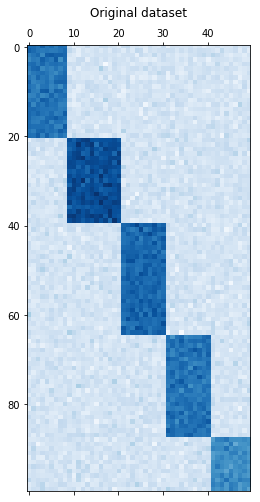

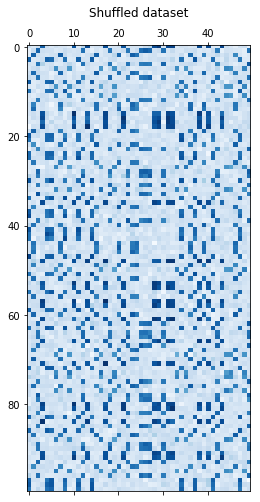

In [241]:
plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Original dataset")

data, row_idx, col_idx = sg._shuffle(data, random_state=0)
plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Shuffled dataset")

In [ ]:
model = Rapooc(data,5,5,10)
model.initialize()
model.core_coclustering()

iter 0
 arg max row
 arg max column
iter 1
 arg max row
 arg max column
iter 2
 arg max row
 arg max column
iter 3
 arg max row
 arg max column
iter 4
 arg max row


In [229]:
model.rho

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [230]:
model.gamma

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [252]:
N = 4
a = np.random.random(20).reshape(4, 5)
print(a)

# Convert it into a 1D array
a_1d = a.flatten()

# Find the indices in the 1D array
idx_1d = a_1d.argsort()[-N:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, a.shape)

# Check that we got the largest values.
for x, y, in zip(x_idx, y_idx):
    print(a[x][y])

[[ 0.08957334  0.36334637  0.90492082  0.09634894  0.64588623]
 [ 0.82355393  0.92560304  0.62818321  0.69514661  0.72090732]
 [ 0.5935621   0.64457202  0.88322596  0.14973624  0.27628812]
 [ 0.35740371  0.91069375  0.6450397   0.68815604  0.1633674 ]]
0.883225959716
0.904920824642
0.910693753878
0.925603036852


In [226]:
fit_data = data[np.argsort(rapooc.rho)]
fit_data = fit_data[:, np.argsort(rapooc.gamma)]

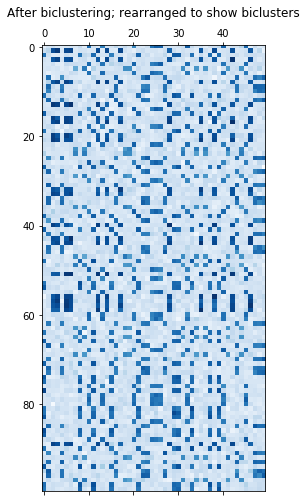

In [227]:
plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()

In [ ]:
a = np.random.random(20).reshape(4, 5)
print(a)

# Convert it into a 1D array
a_1d = a.flatten()

# Find the indices in the 1D array
idx_1d = a_1d.argsort()[-N:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, a.shape)

# Check that we got the largest values.
for x, y, in zip(x_idx, y_idx):
    print(a[x][y])
            

In [83]:
import glob
glob.glob('TestData/SimulatedDataCoherence/*')

['TestData/SimulatedDataCoherence/LowCoherence.csv',
 'TestData/SimulatedDataCoherence/HighCoherenceMix.csv',
 'TestData/SimulatedDataCoherence/MidCoherence.csv',
 'TestData/SimulatedDataCoherence/RandData.csv',
 'TestData/SimulatedDataCoherence/HighCoherence.csv',
 'TestData/SimulatedDataCoherence/LowCoherenceMix.csv',
 'TestData/SimulatedDataCoherence/MidCoherenceMix.csv']

In [76]:
d = np.array(np.array([0,1,2,3,3,3,6,7,8]))
a = d[np.whe]

In [139]:
np.array(data)[np.ix_([0,3],[1,2])]

array([[ 0.013931 ,  0.49935  ],
       [ 0.0067908,  0.50297  ]])

In [69]:



class Cl1:
    def __init__(self):
        self._arr =  np.array(np.array([0,1,2,3,3,3,6,7,8]))
    
    def calc(self):
        num = 0
        self._calc2(num)
        print (self._arr)
    
    def _calc2(self,num):
        n = self._arr
        self._arr[0] = 1

In [70]:
cl = Cl1()
cl.calc()

[1 1 2 3 3 3 6 7 8]
